# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████████████| 60.0K/60.0K [05:21<00:00, 186File/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

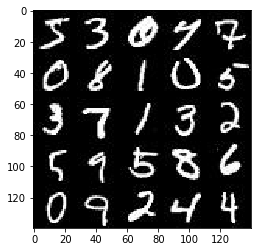

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

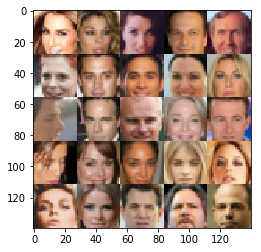

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [106]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real= tf.placeholder(tf.float32, 
                                (None,image_width, image_height, image_channels), 
                                name='input_real')
    inputs_z= tf.placeholder(tf.float32, 
                             (None, z_dim), 
                             name='input_z')
    learning_rate= tf.placeholder(tf.float32, shape=(), name='learning_rate')
    

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [194]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
#         x1 = tf.contrib.layers.dropout(x1, keep_prob=0.6, is_training=True)
        relu1 = tf.maximum(alpha * x1, x1)
        
        #Convolution w/ batch norm & leaky relu 
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=1, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        #Convolution w/ batch norm & leaky relu 
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        #Convolution w/ batch norm & leaky relu 
#         x4 = tf.layers.conv2d(relu3, 512, 5, strides=2, padding='same')
#         bn4 = tf.layers.batch_normalization(x4, training=True)
#         relu4 = tf.maximum(alpha * bn4, bn4)
        
        #Convolution w/ batch norm & leaky relu 
#         x5 = tf.layers.conv2d(relu4, 1024, 5, strides=2, padding='same')
#         bn5 = tf.layers.batch_normalization(x4, training=True)
#         relu5 = tf.maximum(alpha * bn4, bn4)
        
        
        #Flatten
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [189]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        
        #Fully Connected
        x1 = tf.layers.dense(z, 7*7*256)
        
        #Reshape
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
#         x1 = tf.contrib.layers.dropout(x1, keep_prob=0.5, is_training=is_train)
        x1 = tf.maximum(alpha * x1, x1)


        #7x7x512
        
        #Convolutional transpose w/ batch norm & leaky relu
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
    
        #7x7x256
        
        #Convolutional transpose w/ batch norm & leaky relu
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)

        #14x14x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [197]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [29]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [30]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [195]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_every=100, show_batch=1000):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    height = data_shape[1]
    width = data_shape[2]
    depth = data_shape[3]
    
    input_real, input_z, lr = model_inputs(height, width, depth, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, depth)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    samples, losses = [], []
    steps = 0
            
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers (GDG)
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate}) 
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_batch == 0:
                    img = show_generator_output(sess, 25, input_z, depth, data_image_mode)
                    
        saver.save(sess, './checkpoints/generator.ckpt')                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.5840... Generator Loss: 0.3329
Epoch 1/2... Discriminator Loss: 1.7439... Generator Loss: 0.3983
Epoch 1/2... Discriminator Loss: 1.5913... Generator Loss: 0.3220
Epoch 1/2... Discriminator Loss: 1.2410... Generator Loss: 0.8324
Epoch 1/2... Discriminator Loss: 1.4186... Generator Loss: 0.4430
Epoch 1/2... Discriminator Loss: 1.2019... Generator Loss: 0.8421
Epoch 1/2... Discriminator Loss: 1.8711... Generator Loss: 0.2315
Epoch 1/2... Discriminator Loss: 0.9362... Generator Loss: 1.0595
Epoch 1/2... Discriminator Loss: 0.8997... Generator Loss: 0.8963
Epoch 1/2... Discriminator Loss: 1.3851... Generator Loss: 0.4076


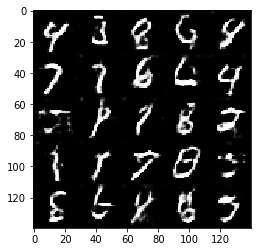

Epoch 1/2... Discriminator Loss: 1.2269... Generator Loss: 0.4791
Epoch 1/2... Discriminator Loss: 1.1815... Generator Loss: 1.0072
Epoch 1/2... Discriminator Loss: 2.3413... Generator Loss: 0.1522
Epoch 1/2... Discriminator Loss: 1.3487... Generator Loss: 0.4627
Epoch 1/2... Discriminator Loss: 1.7421... Generator Loss: 0.2933
Epoch 1/2... Discriminator Loss: 0.9252... Generator Loss: 0.9791
Epoch 1/2... Discriminator Loss: 1.0147... Generator Loss: 0.7322
Epoch 1/2... Discriminator Loss: 1.5918... Generator Loss: 0.4022
Epoch 1/2... Discriminator Loss: 0.6090... Generator Loss: 1.7573
Epoch 1/2... Discriminator Loss: 1.8386... Generator Loss: 0.2956


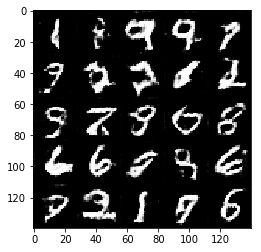

Epoch 1/2... Discriminator Loss: 0.4679... Generator Loss: 1.4212
Epoch 1/2... Discriminator Loss: 0.7350... Generator Loss: 1.6745
Epoch 1/2... Discriminator Loss: 1.5920... Generator Loss: 0.3604
Epoch 1/2... Discriminator Loss: 0.5621... Generator Loss: 3.2608
Epoch 1/2... Discriminator Loss: 1.0634... Generator Loss: 1.0137
Epoch 1/2... Discriminator Loss: 0.8466... Generator Loss: 1.1788
Epoch 1/2... Discriminator Loss: 0.7213... Generator Loss: 1.4655
Epoch 1/2... Discriminator Loss: 0.7617... Generator Loss: 0.9580
Epoch 1/2... Discriminator Loss: 0.5708... Generator Loss: 1.3811
Epoch 1/2... Discriminator Loss: 0.6655... Generator Loss: 1.2592


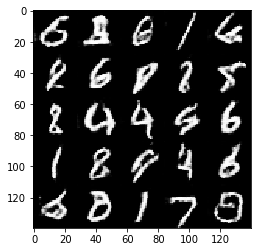

Epoch 1/2... Discriminator Loss: 0.6963... Generator Loss: 1.2655
Epoch 1/2... Discriminator Loss: 0.9116... Generator Loss: 0.6733
Epoch 1/2... Discriminator Loss: 1.0298... Generator Loss: 1.0652
Epoch 1/2... Discriminator Loss: 1.2316... Generator Loss: 0.5694
Epoch 1/2... Discriminator Loss: 0.8793... Generator Loss: 0.9048
Epoch 1/2... Discriminator Loss: 0.5331... Generator Loss: 1.6537
Epoch 1/2... Discriminator Loss: 2.0605... Generator Loss: 0.2253
Epoch 2/2... Discriminator Loss: 0.4853... Generator Loss: 1.2778
Epoch 2/2... Discriminator Loss: 0.8119... Generator Loss: 0.9504
Epoch 2/2... Discriminator Loss: 0.4405... Generator Loss: 1.8437


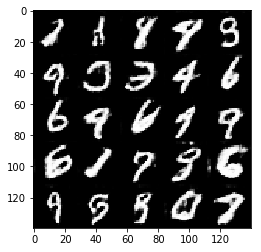

Epoch 2/2... Discriminator Loss: 0.6972... Generator Loss: 0.9359
Epoch 2/2... Discriminator Loss: 0.6845... Generator Loss: 1.2977
Epoch 2/2... Discriminator Loss: 3.3829... Generator Loss: 0.0519
Epoch 2/2... Discriminator Loss: 0.4126... Generator Loss: 1.8037
Epoch 2/2... Discriminator Loss: 1.1209... Generator Loss: 0.7746
Epoch 2/2... Discriminator Loss: 0.5802... Generator Loss: 1.0636
Epoch 2/2... Discriminator Loss: 0.4555... Generator Loss: 1.8179
Epoch 2/2... Discriminator Loss: 0.2285... Generator Loss: 2.3549
Epoch 2/2... Discriminator Loss: 2.4488... Generator Loss: 0.1793
Epoch 2/2... Discriminator Loss: 1.2912... Generator Loss: 0.4938


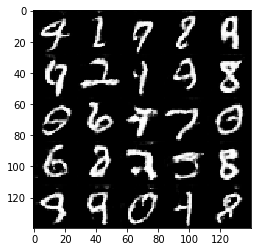

Epoch 2/2... Discriminator Loss: 1.4457... Generator Loss: 0.5947
Epoch 2/2... Discriminator Loss: 1.1339... Generator Loss: 0.6936
Epoch 2/2... Discriminator Loss: 0.7227... Generator Loss: 0.8736
Epoch 2/2... Discriminator Loss: 1.3687... Generator Loss: 0.3919
Epoch 2/2... Discriminator Loss: 1.3677... Generator Loss: 0.5789
Epoch 2/2... Discriminator Loss: 0.9773... Generator Loss: 0.8362
Epoch 2/2... Discriminator Loss: 1.2161... Generator Loss: 0.4178
Epoch 2/2... Discriminator Loss: 1.2380... Generator Loss: 0.9575
Epoch 2/2... Discriminator Loss: 0.9723... Generator Loss: 0.9118
Epoch 2/2... Discriminator Loss: 0.4446... Generator Loss: 1.7783


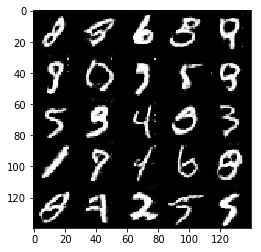

Epoch 2/2... Discriminator Loss: 1.0970... Generator Loss: 0.7889
Epoch 2/2... Discriminator Loss: 2.1348... Generator Loss: 0.2589
Epoch 2/2... Discriminator Loss: 1.2142... Generator Loss: 0.5388
Epoch 2/2... Discriminator Loss: 0.5703... Generator Loss: 1.2483
Epoch 2/2... Discriminator Loss: 1.1120... Generator Loss: 0.7875
Epoch 2/2... Discriminator Loss: 0.8686... Generator Loss: 1.0873
Epoch 2/2... Discriminator Loss: 1.1077... Generator Loss: 0.7499
Epoch 2/2... Discriminator Loss: 0.6208... Generator Loss: 1.5485
Epoch 2/2... Discriminator Loss: 0.2350... Generator Loss: 2.7232
Epoch 2/2... Discriminator Loss: 0.6716... Generator Loss: 1.7199


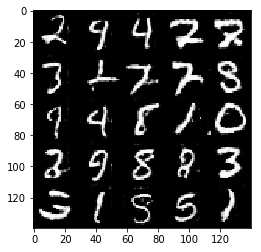

Epoch 2/2... Discriminator Loss: 0.4339... Generator Loss: 1.8304
Epoch 2/2... Discriminator Loss: 0.7927... Generator Loss: 1.1080
Epoch 2/2... Discriminator Loss: 0.7241... Generator Loss: 1.7441
Epoch 2/2... Discriminator Loss: 0.3838... Generator Loss: 1.6984
Epoch 2/2... Discriminator Loss: 0.3829... Generator Loss: 1.9634


In [123]:
batch_size = 16
z_dim = 100
learning_rate = 0.002
alpha=0.2
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2
tf.reset_default_graph()

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/3... Discriminator Loss: 0.9109... Generator Loss: 1.3884
Epoch 1/3... Discriminator Loss: 1.0093... Generator Loss: 1.4673
Epoch 1/3... Discriminator Loss: 0.9540... Generator Loss: 1.0449
Epoch 1/3... Discriminator Loss: 1.2888... Generator Loss: 1.0963
Epoch 1/3... Discriminator Loss: 1.2704... Generator Loss: 0.9180
Epoch 1/3... Discriminator Loss: 1.3250... Generator Loss: 0.7037
Epoch 1/3... Discriminator Loss: 1.3316... Generator Loss: 0.8512
Epoch 1/3... Discriminator Loss: 1.2186... Generator Loss: 1.1681
Epoch 1/3... Discriminator Loss: 1.3551... Generator Loss: 0.8519
Epoch 1/3... Discriminator Loss: 1.2567... Generator Loss: 0.8408


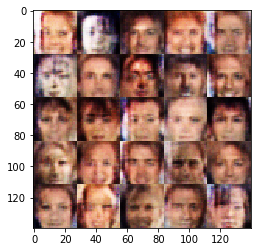

Epoch 1/3... Discriminator Loss: 1.2980... Generator Loss: 0.8131
Epoch 1/3... Discriminator Loss: 1.3314... Generator Loss: 0.7843
Epoch 1/3... Discriminator Loss: 1.3704... Generator Loss: 0.9494
Epoch 1/3... Discriminator Loss: 1.3445... Generator Loss: 0.9382
Epoch 1/3... Discriminator Loss: 1.3134... Generator Loss: 0.8157
Epoch 1/3... Discriminator Loss: 1.4189... Generator Loss: 0.8188
Epoch 1/3... Discriminator Loss: 1.4916... Generator Loss: 0.6796
Epoch 1/3... Discriminator Loss: 1.3856... Generator Loss: 0.9154
Epoch 1/3... Discriminator Loss: 1.4642... Generator Loss: 0.8097
Epoch 1/3... Discriminator Loss: 1.3576... Generator Loss: 0.8711


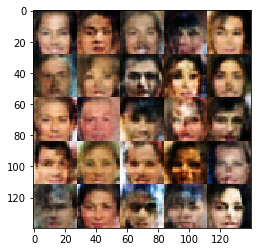

Epoch 1/3... Discriminator Loss: 1.4613... Generator Loss: 0.7225
Epoch 1/3... Discriminator Loss: 1.5240... Generator Loss: 0.7284
Epoch 1/3... Discriminator Loss: 1.4110... Generator Loss: 0.7383
Epoch 1/3... Discriminator Loss: 1.3801... Generator Loss: 0.7624
Epoch 1/3... Discriminator Loss: 1.3817... Generator Loss: 0.7781
Epoch 1/3... Discriminator Loss: 1.3381... Generator Loss: 0.7896
Epoch 1/3... Discriminator Loss: 1.3590... Generator Loss: 0.8600
Epoch 1/3... Discriminator Loss: 1.3713... Generator Loss: 0.8760
Epoch 1/3... Discriminator Loss: 1.4819... Generator Loss: 0.6253
Epoch 1/3... Discriminator Loss: 1.3472... Generator Loss: 0.7925


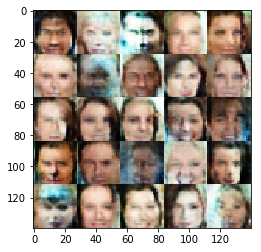

Epoch 1/3... Discriminator Loss: 1.3552... Generator Loss: 0.7208
Epoch 1/3... Discriminator Loss: 1.3495... Generator Loss: 0.7584
Epoch 1/3... Discriminator Loss: 1.3066... Generator Loss: 0.8177
Epoch 1/3... Discriminator Loss: 1.3886... Generator Loss: 0.7447
Epoch 1/3... Discriminator Loss: 1.4277... Generator Loss: 0.7435
Epoch 1/3... Discriminator Loss: 1.3676... Generator Loss: 0.7871
Epoch 1/3... Discriminator Loss: 1.3299... Generator Loss: 0.8740
Epoch 1/3... Discriminator Loss: 1.3952... Generator Loss: 0.6924
Epoch 1/3... Discriminator Loss: 1.3980... Generator Loss: 0.7060
Epoch 1/3... Discriminator Loss: 1.3293... Generator Loss: 0.7655


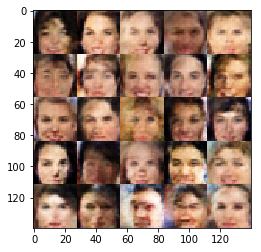

Epoch 1/3... Discriminator Loss: 1.3966... Generator Loss: 0.8322
Epoch 1/3... Discriminator Loss: 1.3357... Generator Loss: 0.8857
Epoch 1/3... Discriminator Loss: 1.3486... Generator Loss: 0.8251
Epoch 1/3... Discriminator Loss: 1.4155... Generator Loss: 0.8878
Epoch 1/3... Discriminator Loss: 1.4088... Generator Loss: 0.6915
Epoch 1/3... Discriminator Loss: 1.4096... Generator Loss: 0.7035
Epoch 1/3... Discriminator Loss: 1.3574... Generator Loss: 0.8680
Epoch 1/3... Discriminator Loss: 1.3558... Generator Loss: 0.9233
Epoch 1/3... Discriminator Loss: 1.3703... Generator Loss: 0.7549
Epoch 1/3... Discriminator Loss: 1.3247... Generator Loss: 0.9133


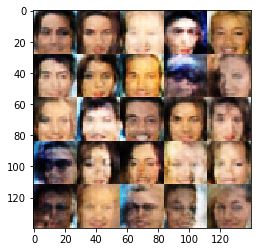

Epoch 1/3... Discriminator Loss: 1.3937... Generator Loss: 0.7582
Epoch 1/3... Discriminator Loss: 1.3798... Generator Loss: 0.7414
Epoch 1/3... Discriminator Loss: 1.3854... Generator Loss: 0.7934
Epoch 1/3... Discriminator Loss: 1.3994... Generator Loss: 0.9229
Epoch 1/3... Discriminator Loss: 1.4445... Generator Loss: 0.7356
Epoch 1/3... Discriminator Loss: 1.3152... Generator Loss: 0.8676
Epoch 1/3... Discriminator Loss: 1.3264... Generator Loss: 0.9279
Epoch 1/3... Discriminator Loss: 1.3704... Generator Loss: 0.7929
Epoch 1/3... Discriminator Loss: 1.3764... Generator Loss: 0.9790
Epoch 1/3... Discriminator Loss: 1.4171... Generator Loss: 0.8489


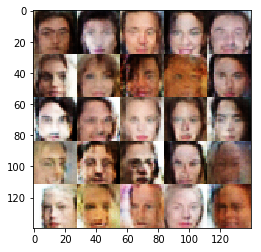

Epoch 1/3... Discriminator Loss: 1.4385... Generator Loss: 0.6536
Epoch 1/3... Discriminator Loss: 1.3593... Generator Loss: 0.8023
Epoch 1/3... Discriminator Loss: 1.3938... Generator Loss: 0.7475
Epoch 2/3... Discriminator Loss: 1.3810... Generator Loss: 0.8848
Epoch 2/3... Discriminator Loss: 1.4096... Generator Loss: 0.9094
Epoch 2/3... Discriminator Loss: 1.3983... Generator Loss: 0.8063
Epoch 2/3... Discriminator Loss: 1.3670... Generator Loss: 0.7793
Epoch 2/3... Discriminator Loss: 1.4051... Generator Loss: 0.7822
Epoch 2/3... Discriminator Loss: 1.3776... Generator Loss: 0.8308
Epoch 2/3... Discriminator Loss: 1.3754... Generator Loss: 0.7769


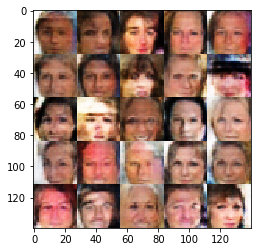

Epoch 2/3... Discriminator Loss: 1.3668... Generator Loss: 0.8614
Epoch 2/3... Discriminator Loss: 1.3601... Generator Loss: 0.8931
Epoch 2/3... Discriminator Loss: 1.3886... Generator Loss: 0.8315
Epoch 2/3... Discriminator Loss: 1.4103... Generator Loss: 0.6486
Epoch 2/3... Discriminator Loss: 1.3736... Generator Loss: 0.7719
Epoch 2/3... Discriminator Loss: 1.3912... Generator Loss: 0.7325
Epoch 2/3... Discriminator Loss: 1.3650... Generator Loss: 0.8034
Epoch 2/3... Discriminator Loss: 1.3748... Generator Loss: 0.8236
Epoch 2/3... Discriminator Loss: 1.3345... Generator Loss: 0.9323
Epoch 2/3... Discriminator Loss: 1.3505... Generator Loss: 0.8299


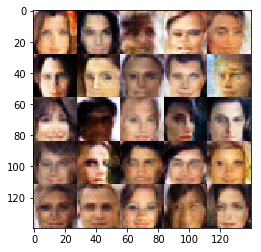

Epoch 2/3... Discriminator Loss: 1.3658... Generator Loss: 0.9506
Epoch 2/3... Discriminator Loss: 1.3873... Generator Loss: 0.8903
Epoch 2/3... Discriminator Loss: 1.3359... Generator Loss: 0.8158
Epoch 2/3... Discriminator Loss: 1.4541... Generator Loss: 0.6147
Epoch 2/3... Discriminator Loss: 1.3736... Generator Loss: 0.8159
Epoch 2/3... Discriminator Loss: 1.4044... Generator Loss: 0.8074
Epoch 2/3... Discriminator Loss: 1.3880... Generator Loss: 0.8809
Epoch 2/3... Discriminator Loss: 1.3584... Generator Loss: 0.7947
Epoch 2/3... Discriminator Loss: 1.4091... Generator Loss: 0.8214
Epoch 2/3... Discriminator Loss: 1.4230... Generator Loss: 0.7913


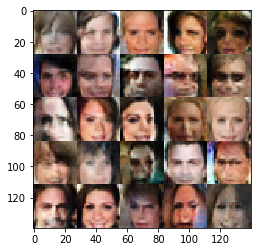

Epoch 2/3... Discriminator Loss: 1.3508... Generator Loss: 0.8493
Epoch 2/3... Discriminator Loss: 1.3562... Generator Loss: 0.8754
Epoch 2/3... Discriminator Loss: 1.3667... Generator Loss: 0.7382
Epoch 2/3... Discriminator Loss: 1.3723... Generator Loss: 0.7859
Epoch 2/3... Discriminator Loss: 1.4231... Generator Loss: 0.7559
Epoch 2/3... Discriminator Loss: 1.3589... Generator Loss: 0.7910
Epoch 2/3... Discriminator Loss: 1.3563... Generator Loss: 0.8792
Epoch 2/3... Discriminator Loss: 1.3756... Generator Loss: 0.7578
Epoch 2/3... Discriminator Loss: 1.3764... Generator Loss: 0.8420
Epoch 2/3... Discriminator Loss: 1.3579... Generator Loss: 0.7429


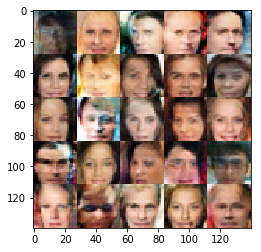

Epoch 2/3... Discriminator Loss: 1.3786... Generator Loss: 0.7690
Epoch 2/3... Discriminator Loss: 1.3966... Generator Loss: 0.9376
Epoch 2/3... Discriminator Loss: 1.3936... Generator Loss: 0.7301
Epoch 2/3... Discriminator Loss: 1.3766... Generator Loss: 0.7259
Epoch 2/3... Discriminator Loss: 1.4081... Generator Loss: 0.7120
Epoch 2/3... Discriminator Loss: 1.3755... Generator Loss: 0.7508
Epoch 2/3... Discriminator Loss: 1.3863... Generator Loss: 0.7158
Epoch 2/3... Discriminator Loss: 1.3458... Generator Loss: 0.7557
Epoch 2/3... Discriminator Loss: 1.3420... Generator Loss: 0.8318
Epoch 2/3... Discriminator Loss: 1.3727... Generator Loss: 0.7582


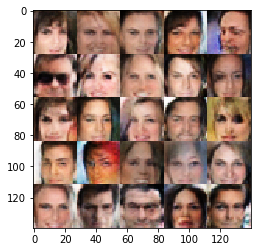

Epoch 2/3... Discriminator Loss: 1.3806... Generator Loss: 0.8254
Epoch 2/3... Discriminator Loss: 1.3653... Generator Loss: 0.8238
Epoch 2/3... Discriminator Loss: 1.3606... Generator Loss: 0.7098
Epoch 2/3... Discriminator Loss: 1.3851... Generator Loss: 0.7654
Epoch 2/3... Discriminator Loss: 1.3615... Generator Loss: 0.7573
Epoch 2/3... Discriminator Loss: 1.3678... Generator Loss: 0.8179
Epoch 2/3... Discriminator Loss: 1.4027... Generator Loss: 0.7853
Epoch 2/3... Discriminator Loss: 1.3833... Generator Loss: 0.7730
Epoch 2/3... Discriminator Loss: 1.3755... Generator Loss: 0.8156
Epoch 2/3... Discriminator Loss: 1.3896... Generator Loss: 0.7640


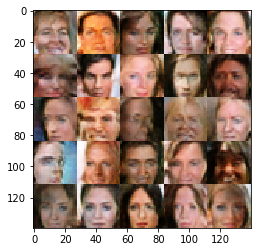

Epoch 2/3... Discriminator Loss: 1.3847... Generator Loss: 0.6760
Epoch 2/3... Discriminator Loss: 1.3392... Generator Loss: 0.8765
Epoch 2/3... Discriminator Loss: 1.3758... Generator Loss: 0.8123
Epoch 2/3... Discriminator Loss: 1.3970... Generator Loss: 0.6712
Epoch 2/3... Discriminator Loss: 1.3647... Generator Loss: 0.8177
Epoch 2/3... Discriminator Loss: 1.3611... Generator Loss: 0.7109
Epoch 3/3... Discriminator Loss: 1.3350... Generator Loss: 0.9150
Epoch 3/3... Discriminator Loss: 1.3598... Generator Loss: 0.8361
Epoch 3/3... Discriminator Loss: 1.3682... Generator Loss: 0.7318
Epoch 3/3... Discriminator Loss: 1.3718... Generator Loss: 0.8818


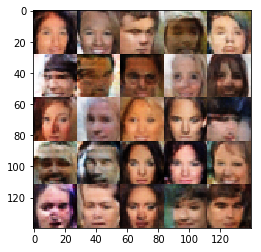

Epoch 3/3... Discriminator Loss: 1.3517... Generator Loss: 0.8752
Epoch 3/3... Discriminator Loss: 1.3633... Generator Loss: 0.7231
Epoch 3/3... Discriminator Loss: 1.3666... Generator Loss: 0.8353
Epoch 3/3... Discriminator Loss: 1.3468... Generator Loss: 0.7537
Epoch 3/3... Discriminator Loss: 1.4104... Generator Loss: 0.8003
Epoch 3/3... Discriminator Loss: 1.3740... Generator Loss: 0.8141
Epoch 3/3... Discriminator Loss: 1.3721... Generator Loss: 0.7324
Epoch 3/3... Discriminator Loss: 1.3625... Generator Loss: 0.7481
Epoch 3/3... Discriminator Loss: 1.3927... Generator Loss: 0.8943
Epoch 3/3... Discriminator Loss: 1.3955... Generator Loss: 0.6787


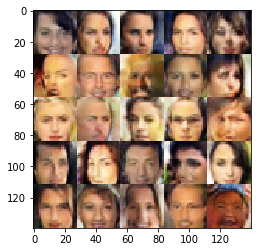

Epoch 3/3... Discriminator Loss: 1.3463... Generator Loss: 0.8887
Epoch 3/3... Discriminator Loss: 1.3482... Generator Loss: 0.8863
Epoch 3/3... Discriminator Loss: 1.3418... Generator Loss: 0.8144
Epoch 3/3... Discriminator Loss: 1.3750... Generator Loss: 0.7800
Epoch 3/3... Discriminator Loss: 1.3394... Generator Loss: 0.8695
Epoch 3/3... Discriminator Loss: 1.3502... Generator Loss: 0.8424
Epoch 3/3... Discriminator Loss: 1.3665... Generator Loss: 0.6885
Epoch 3/3... Discriminator Loss: 1.3624... Generator Loss: 0.8005
Epoch 3/3... Discriminator Loss: 1.3534... Generator Loss: 0.9213
Epoch 3/3... Discriminator Loss: 1.3728... Generator Loss: 0.7474


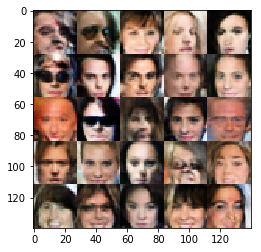

Epoch 3/3... Discriminator Loss: 1.3821... Generator Loss: 0.7317
Epoch 3/3... Discriminator Loss: 1.3498... Generator Loss: 0.8150
Epoch 3/3... Discriminator Loss: 1.3539... Generator Loss: 0.7935
Epoch 3/3... Discriminator Loss: 1.3351... Generator Loss: 0.9220
Epoch 3/3... Discriminator Loss: 1.3544... Generator Loss: 0.7403
Epoch 3/3... Discriminator Loss: 1.3626... Generator Loss: 0.8246
Epoch 3/3... Discriminator Loss: 1.3587... Generator Loss: 0.8285
Epoch 3/3... Discriminator Loss: 1.3736... Generator Loss: 0.7992
Epoch 3/3... Discriminator Loss: 1.4093... Generator Loss: 0.9449
Epoch 3/3... Discriminator Loss: 1.4235... Generator Loss: 0.6214


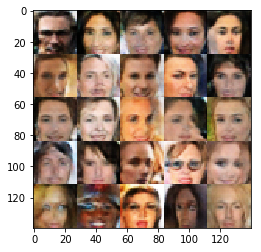

Epoch 3/3... Discriminator Loss: 1.3562... Generator Loss: 0.7150
Epoch 3/3... Discriminator Loss: 1.3712... Generator Loss: 0.7729
Epoch 3/3... Discriminator Loss: 1.3972... Generator Loss: 0.7343
Epoch 3/3... Discriminator Loss: 1.3441... Generator Loss: 0.8187
Epoch 3/3... Discriminator Loss: 1.3264... Generator Loss: 0.9798
Epoch 3/3... Discriminator Loss: 1.3545... Generator Loss: 0.7572
Epoch 3/3... Discriminator Loss: 1.3722... Generator Loss: 0.7369
Epoch 3/3... Discriminator Loss: 1.3556... Generator Loss: 0.9280
Epoch 3/3... Discriminator Loss: 1.3542... Generator Loss: 0.7972
Epoch 3/3... Discriminator Loss: 1.3102... Generator Loss: 0.8691


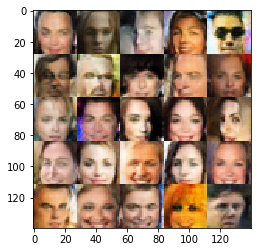

Epoch 3/3... Discriminator Loss: 1.3638... Generator Loss: 0.8765
Epoch 3/3... Discriminator Loss: 1.3366... Generator Loss: 0.8058
Epoch 3/3... Discriminator Loss: 1.3356... Generator Loss: 0.7442
Epoch 3/3... Discriminator Loss: 1.3327... Generator Loss: 0.7742
Epoch 3/3... Discriminator Loss: 1.3732... Generator Loss: 0.8528
Epoch 3/3... Discriminator Loss: 1.3186... Generator Loss: 0.8148
Epoch 3/3... Discriminator Loss: 1.3803... Generator Loss: 0.7086
Epoch 3/3... Discriminator Loss: 1.3817... Generator Loss: 0.7251
Epoch 3/3... Discriminator Loss: 1.3751... Generator Loss: 0.7917
Epoch 3/3... Discriminator Loss: 1.3486... Generator Loss: 0.9187


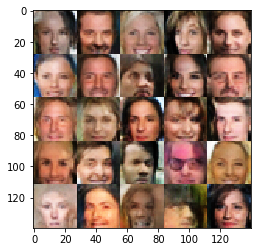

Epoch 3/3... Discriminator Loss: 1.3322... Generator Loss: 0.7736
Epoch 3/3... Discriminator Loss: 1.3851... Generator Loss: 0.6993
Epoch 3/3... Discriminator Loss: 1.3330... Generator Loss: 0.7894
Epoch 3/3... Discriminator Loss: 1.3487... Generator Loss: 0.8075
Epoch 3/3... Discriminator Loss: 1.3529... Generator Loss: 0.7257
Epoch 3/3... Discriminator Loss: 1.3845... Generator Loss: 1.0100
Epoch 3/3... Discriminator Loss: 1.3529... Generator Loss: 0.8301
Epoch 3/3... Discriminator Loss: 1.3337... Generator Loss: 0.8433
Epoch 3/3... Discriminator Loss: 1.3472... Generator Loss: 0.7994


In [198]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
alpha=0.2
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.